# Simple is Best 팀  
### 오혁준 최고운 박연재 김민솔 김영찬

# 필요한 라이브러리 다운로드

In [1]:
%pip install pandas==2.2.0 numpy==1.25.2 lightgbm==4.1.0 seaborn==0.13.1 pycountry==20.7.3 catboost==1.2.2 optuna==3.5.0 scikit-learn==1.2.2 gensim==4.3.2 nbformat plotly --upgrade

In [2]:
import os, random, sys

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool


import time
from gensim.models import FastText
import re

import warnings
warnings.filterwarnings('ignore')
import joblib

from multiprocessing import Pool
from functools import partial

import pycountry

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [3]:
print(f"- python: {sys.version}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")

- python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
- pandas: 2.2.0
- numpy: 1.25.2
- sklearn: 1.2.2


# Fix Seed

In [4]:
# fix seed
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Load

In [6]:
train = pd.read_csv("/content/drive/MyDrive/LG Aimers/train.csv")
test = pd.read_csv("/content/drive/MyDrive/LG Aimers/submission.csv")

In [7]:
# train 데이터를 train과 valid 데이터로 분할
x_train, x_val, y_train, y_val = train_test_split(
    train.drop("is_converted", axis=1),
    train["is_converted"],
    test_size=0.2, # 비율 train : valid = 8 : 2
    shuffle=True, # 데이터의 class가 편중되는 것을 방지
    random_state=SEED,
    stratify = train["is_converted"] # train/valid 데이터의 class 비율을 동일하게
)

# Data Preprocessing

## product_category, product_subcategory, product_modelname
**담당 : 최고운**  
  
- product_category의 경우 같은 제품군끼리 묶어 범주의 개수를 축소하고자 FastText로 워드 임베딩을 수행한 후 K-means 군집화를 진행했습니다. 이후 군집의 개수 만큼 column을 추가하여 multi-label binarization을 수행했습니다.
- product_category, product_subcategory, product_modelname을 값 작성 여부에 따라 0/1로 값을 변경했습니다

#### Product_category

In [8]:
# 워드 임베딩을 위한 데이터 준비

# 한 명의 고객이 여러 제품군을 요청하는 경우가 존재하므로, 제품군 각각의 임베딩 벡터를 얻고자 split 수행
def split_data(df):
  pc_str = ""
  for elem in df["product_category"].unique():
      if not pd.isna(elem):
          pc_str += str(elem)+","
  splited_values = pd.Series(pc_str.split(",")[:-1])

  return splited_values

# 각 데이터 세트에 대해 split_data 함수 적용
train_splited_values = split_data(x_train)
val_splited_values = split_data(x_val)
test_splited_values = split_data(test)

In [9]:
# 워드 임베딩 & 군집화 수행

# 앞서 나눠 둔 train 데이터에 대해서 FastText 모델과 K-means 모델을 fit하고 모델을 저장
def clustering_for_train(train, train_splited_values):
    train_values = []
    for elem in train_splited_values:
        train_values.append([elem])

    # 워드 임베딩 모델 학습 및 저장
    embedding_model = FastText(train_values, vector_size=100, window=5, min_count=1, workers=4, sg=1, seed=1234)
    embedding_model.save("ft_product_category")

    # 단어와 대응되는 임베딩 벡터 추출
    train_word_vectors = embedding_model.wv
    train_words = list(train_word_vectors.key_to_index.keys())
    train_vectors = [train_word_vectors[word] for word in train_words]

    # 단어들 간의 코사인 유사도 계산
    similarity_matrix = cosine_similarity(train_vectors)

    # 단어 유사도 행렬을 입력으로 K-means clustering 및 모델 저장
    num_clusters = 18  # 클러스터 수 설정 (실루엣, 엘보우 기반)
    kmeans = KMeans(n_clusters=num_clusters, random_state=1234)
    kmeans_cluster_assignments = kmeans.fit_predict(similarity_matrix)
    joblib.dump(kmeans, 'kmeans_clustering_model.pkl')

    # multi-label binarization(요청 제품군들이 속하는 클러스터에 대해서 1값을 부여)
    # [apple(cluster0), banana(cluster2)] => [1,0,1]
    new_train_col = []
    for elem in train["product_category"]: # 행마다 속하는 군집 파악
        if not pd.isna(elem):
            splited = elem.split(",")
            clu_nums = []
            for product in splited:
                if product != "":
                    idx = train_word_vectors.key_to_index[product]
                    clu_nums.append(kmeans_cluster_assignments[idx])
            new_train_col.append(list(set(clu_nums))) # 같은 군집에 속하는 제품이 2개 이상인 경우 처리
        else:
            new_train_col.append(np.nan)

    # 클러스터 개수만큼 0으로 채워진 컬럼 생성
    for i in range(num_clusters):
        train[f"cluster{i}"] = np.zeros((train["product_category"].shape[0],))

    # 행마다 속하는 군집들에 대해 1값을 부여
    for idx,elem in enumerate(new_train_col):
        if type(elem)!=float: # nan이 아닌 경우에만 처리
            for pos in elem:
                train[f"cluster{pos}"].iloc[idx] = 1

    return train, train_vectors, num_clusters

# train 세트에 대해 clustering_for_train 함수 적용
x_train, train_vectors, num_clusters = clustering_for_train(x_train, train_splited_values)

In [10]:
# 나눠둔 validation 데이터와 test 데이터에 대해 train 데이터로 학습된 FastText 모델, K-means 모델을 predict
def clustering_for_test(test, train_vectors, test_splited_values, num_clusters):
  # 학습한 임베딩 모델 load
  embedding_model = FastText.load("ft_product_category")

  # validation/test에 대해서 임베딩 벡터 생성
  test_words = test_splited_values.unique().tolist()
  test_vectors = [embedding_model.wv.get_vector(words) for words in test_words]

  # train을 기준으로 생성한 클러스터들을 기준으로 validation/test의 데이터가 어떤 클러스터에 속할지 예측(군집예측)
  clustering_model = joblib.load('kmeans_clustering_model.pkl')
  # train 데이터와의 코사인 유사도 계산
  test_similarity_matrix = cosine_similarity(test_vectors, train_vectors)

  # 군집 예측 수행
  test_kmeans_cluster_assignments = clustering_model.predict(test_similarity_matrix)

  # multi-label binarization(요청 제품군들이 속하는 클러스터에 대해서 1값을 부여)
  # [apple(cluster0), banana(cluster2)] => [1,0,1]
  new_test_col = []
  for elem in test["product_category"]: # 행마다 속하는 군집 파악
      if not pd.isna(elem):
          splited = elem.split(",")
          clu_nums = []
          for product in splited:
              if product != "":
                  idx = test_words.index(product)
                  clu_nums.append(test_kmeans_cluster_assignments[idx])
          new_test_col.append(list(set(clu_nums))) # 같은 군집에 속하는 제품이 2개 이상인 경우 처리
      else:
          new_test_col.append(np.nan)

  # 클러스터 개수만큼 0으로 채워진 컬럼 생성
  for i in range(num_clusters):
    test[f"cluster{i}"] = np.zeros((test["product_category"].shape[0],))

  # 행마다 속하는 군집들에 대해 1값을 부여
  for idx,elem in enumerate(new_test_col):
    if type(elem)==list: # nan이 아닌 경우에만 처리
        for pos in elem:
            test[f"cluster{pos}"].iloc[idx] = 1

  return test

# validation, test 세트에 대해 clustering_for_test 함수 적용
x_val = clustering_for_test(x_val, train_vectors, val_splited_values, num_clusters)
test = clustering_for_test(test, train_vectors, test_splited_values, num_clusters)

In [11]:
# product_category, product_subcategory, product_modelname 에 대해 값 작성 여부에 따라 0/1 값을 갖도록 변경
def create_derived_var(df):
  # 대상 컬럼 리스트
  target_cols = ["product_category", "product_subcategory", "product_modelname"]
  # 대상 컬럼을 순회하며 처리
  for column_name in target_cols:
    # 해당 컬럼의 null이 아닌 값은 1로, null인 값은 0으로 변환
    df[column_name] = df[column_name].notnull().astype(int)
  # 변환된 데이터프레임 반환
  return df

# 각 데이터 세트에 대해 create_derived_var 함수 적용
x_train = create_derived_var(x_train)
x_val = create_derived_var(x_val)
test = create_derived_var(test)

## ver_cus, ver_pro, ver_win_rate_x, ver_win_ratio_per_bu, business_area, business_subarea
**담당 : 김영찬**

In [12]:
def fill_na_1(df):
  # 'id_strategic_ver' 컬럼: 값이 있으면 'Y', 없으면 'N'으로 설정
  df['id_strategic_ver'] = np.where(df['id_strategic_ver'].notnull(), 'Y', 'N')

  # 'it_strategic_ver' 컬럼: 값이 있으면 'Y', 없으면 'N'으로 설정
  df['it_strategic_ver'] = np.where(df['it_strategic_ver'].notnull(), 'Y', 'N')

  # 'business_area', 'business_subarea' 컬럼: 결측치를 'Not Entered'로 채움
  df['business_area'] = df['business_area'].fillna('Not Entered')
  df['business_subarea'] = df['business_subarea'].fillna('Not Entered')

  # 'ver_win_rate_x' 컬럼: 결측치를 해당 컬럼의 중앙값으로 채움
  df['ver_win_rate_x'] = df['ver_win_rate_x'].fillna(df['ver_win_rate_x'].median())

  # 'ver_win_ratio_per_bu' 컬럼: 'business_unit' 값에 따라 각 그룹의 중앙값으로 결측치를 대체
  # 'AS' 비즈니스 유닛의 경우
  df[df['business_unit']=='AS']['ver_win_ratio_per_bu'].replace(np.nan, df[df['business_unit']=='AS']['ver_win_ratio_per_bu'].median())
  # 'ID' 비즈니스 유닛의 경우
  df[df['business_unit']=='ID']['ver_win_ratio_per_bu'].replace(np.nan, df[df['business_unit']=='ID']['ver_win_ratio_per_bu'].median())
  # 그 외의 경우, 결측치를 0으로 설정
  df['ver_win_ratio_per_bu'] = df['ver_win_ratio_per_bu'].fillna(0)

  return df

# 각 데이터 세트에 대해 fill_na_1 함수 적용
x_train = fill_na_1(x_train)
x_val = fill_na_1(x_val)
test = fill_na_1(test)

## response_corporate, historical_existing_cnt, business_unit, com_reg_ver_win_rate, lead_owner
**담당 : 김민솔**

In [13]:
def fill_na_2(df):
    # 'historical_existing_cnt' 열의 결측치를 -1로 대체
    df['historical_existing_cnt'] = df['historical_existing_cnt'].fillna(-1)
    return df

# 각 데이터 세트에 대해 fill_na_2 함수 적용
x_train=fill_na_2(x_train)
x_val=fill_na_2(x_val)
test=fill_na_2(test)

In [14]:
def find_rate(df, target_rate, bin_size):
    # com_reg_ver_win_rate 컬럼을 기준으로 구간을 나누고, 해당 구간별로 is_converted 컬럼의 평균을 계산합니다.
    df['crv_win_rate_add'] = pd.cut(df['com_reg_ver_win_rate'], bins=np.arange(0, 1.1, bin_size))
    # 각 구간별 is_converted의 평균을 계산합니다.
    converted_rate = df.groupby('crv_win_rate_add')['is_converted'].mean().reset_index()
    # 목표 전환율(target_rate)에 가장 가까운 구간의 전환율을 찾습니다.
    closest_rate = converted_rate.iloc[(converted_rate['is_converted'] - target_rate).abs().idxmin()]
    return closest_rate

def calculate_bin_mean(bin_interval):
    # 구간(bin_interval)의 평균값을 계산합니다.
    return np.mean([bin_interval.left, bin_interval.right])

def fill_na_3(df):
    # com_reg_ver_win_rate 컬럼의 결측값을 구간의 평균값(mean_of_bin)으로 채웁니다.
    df['com_reg_ver_win_rate'] = df['com_reg_ver_win_rate'].fillna(mean_of_bin)
    return df

# x_train과 y_train을 병합하여 train_tmp 데이터프레임을 생성합니다.
train_tmp = pd.concat([x_train,y_train],axis=1)
target_rate = 0.080123  # 목표 전환율
bin_size = 0.02  # 구간의 크기

# 목표 전환율에 가장 가까운 구간의 전환율 정보를 찾습니다.
closest_rate_result = find_rate(train_tmp, target_rate, bin_size)
# 찾은 구간의 평균값을 계산합니다.
mean_of_bin = calculate_bin_mean(closest_rate_result['crv_win_rate_add'])

# 각 데이터 세트에 대해 fill_na_3 함수 적용
x_train = fill_na_3(x_train)
x_val = fill_na_3(x_val)
test = fill_na_3(test)

## lead_desc_length, inquiry_type, customer_position, expected_timeline, enterprise
담당 : 박연재

In [15]:
# 데이터 소문자화, 띄어쓰기, 특수문자 제거하는 전처리 함수
def preprocess_feature(feature):
  if isinstance(feature, str):  # 문자열인 경우에만 전처리 수행
    # 소문자로 변환
    feature = feature.lower()
    # 특수문자 제거
    feature = re.sub(r'[^a-zA-Z0-9]', '', feature)
    # 공백 제거
    feature = feature.replace(" ", "")
  return feature

# 데이터 결측치 처리 및 범주화 함수
def fill_na_4(df):
  # 'inquiry_type', 'customer_position', 'expected_timeline' 열에 대해 preprocess_feature 함수를 적용
  df['inquiry_type'] = df['inquiry_type'].apply(preprocess_feature)
  df['customer_position'] = df['customer_position'].apply(preprocess_feature)
  df['expected_timeline'] = df['expected_timeline'].apply(preprocess_feature)

  # 'inquiry_type', 'expected_timeline 열에 대해 결측치 처리
  df['inquiry_type'] = df['inquiry_type'].fillna('quotationorpurchaseconsultation')
  df['expected_timeline'] = df['expected_timeline'].fillna('unknown')

  # 각 열의 값에 대한 빈도수 계산
  customer_position_counts = df['customer_position'].value_counts()
  inquiry_type_counts = df['inquiry_type'].value_counts()
  expected_timeline_counts = df['expected_timeline'].value_counts()

  # 빈도수가 특정 임계값(threshold) 이하인 값을 'other'로 변경
  positions_to_replace = customer_position_counts[customer_position_counts <= 24].index
  inquiry_type_to_replace = inquiry_type_counts[inquiry_type_counts <= 20].index
  expected_timeline_to_replace = expected_timeline_counts[expected_timeline_counts <= 10].index

  # 임계값 이하인 값들을 'other'로 대체
  df['inquiry_type'] = df['inquiry_type'].replace(inquiry_type_to_replace, 'other')
  df['customer_position'] = df['customer_position'].replace(positions_to_replace, 'other')
  df['expected_timeline'] = df['expected_timeline'].replace(expected_timeline_to_replace, 'other')

  return df

# 각 데이터 세트에 대해 fill_na_4 함수 적용
x_train = fill_na_4(x_train)
x_val = fill_na_4(x_val)
test = fill_na_4(test)


## bant_submit, customer_country, customer_idx, customer_type, customer_job
담당 : 오혁준

In [16]:
def preprocess_country_column(df, column_name):
    # 모든 국가 이름을 소문자로 변환하여 리스트로 저장
    countries = [country.name.lower() for country in pycountry.countries]

    def convert_to_country_name(item):
        # 입력값이 null이 아닌 경우 소문자로 변환, null인 경우 'Not Entered' 반환
        if pd.notnull(item):
            item_lower = item.lower()
        else:
            return 'Not Entered'

        # 입력값이 빈 문자열인 경우 'Not Entered' 반환
        if item_lower == '':
            return 'Not Entered'

        # 가장 긴 일치하는 국가 이름을 찾기 위한 변수 초기화
        longest_match_country = None
        longest_match_length = 0

        # 입력 항목을 단어 단위로 분리하여 각 단어 검사
        for country in countries:
            if country in item_lower:
                # 가장 긴 일치하는 국가 이름 업데이트
                if len(country) > longest_match_length:
                    longest_match_country = country
                    longest_match_length = len(country)

        # 가장 긴 일치하는 국가 이름이 존재하는 경우, 첫 글자를 대문자로 변환하여 반환
        if longest_match_country:
            return longest_match_country.title()

        # 일치하는 국가 이름이 없는 경우 'other city' 반환
        return 'other city'

    # 주어진 컬럼에 대해 convert_to_country_name 함수를 적용하여 국가 이름 변환
    df[column_name] = df[column_name].apply(convert_to_country_name)

    # 국가별 출현 횟수 계산
    customer_country_counts = df[column_name].value_counts()
    # 20번 미만으로 출현한 국가 이름 리스트 생성
    customer_country_replace = customer_country_counts[customer_country_counts < 20].index.tolist()

    # 출현 횟수가 20번 미만인 국가 이름을 'other country'로 변경
    df.loc[df[column_name].isin(customer_country_replace), column_name] = 'other country'

    # 중복 컬럼 제거 (예: 'customer_country.1', 'idit_strategic_ver')
    df.drop(columns=["customer_country.1", "idit_strategic_ver"], inplace=True)

    return df

# 각 데이터 세트에 대해 preprocess_country_column 함수 적용
x_train = preprocess_country_column(x_train, 'customer_country')
x_val = preprocess_country_column(x_val, 'customer_country')
test = preprocess_country_column(test, 'customer_country')

In [17]:
def fill_na_5(df):
  # 'customer_type'과 'customer_job' 피처(열)에 대해 'preprocess_feature' 함수를 적용하여 전처리합니다.
  df['customer_type'] = df['customer_type'].apply(preprocess_feature)
  df['customer_job'] = df['customer_job'].apply(preprocess_feature)

  # 'customer_type'과 'customer_job' 열의 결측값(NaN)을 'Not Entered'로 채웁니다.
  df['customer_type'] = df['customer_type'].fillna('Not Entered')
  df['customer_job'] = df['customer_job'].fillna('Not Entered')

  # 'customer_type'과 'customer_job'의 각 값에 대한 빈도수를 계산합니다.
  customer_type_counts = df['customer_type'].value_counts()
  customer_job_counts = df['customer_job'].value_counts()

  # 빈도수가 10 이하인 'customer_type'과 40 이하인 'customer_job'의 값을 찾아 리스트로 만듭니다.
  customer_type_to_replace = customer_type_counts[customer_type_counts <= 10].index
  customer_job_to_replace = customer_job_counts[customer_job_counts <= 40].index

  # 빈도수가 낮은 값을 'other types'와 'other jobs'로 대체합니다.
  df['customer_type'] = df['customer_type'].replace(customer_type_to_replace, 'other types')
  df['customer_job'] = df['customer_job'].replace(customer_job_to_replace, 'other jobs')

  return df

# 각 데이터 세트에 대해 fill_na_5 함수 적용
x_train = fill_na_5(x_train)
x_val = fill_na_5(x_val)
test = fill_na_5(test)

##lead_date, transfer_agreement, lead_from_channel

In [18]:
def fill_na_6(df):
    df['lead_date'] = pd.to_datetime(df['lead_date']) #날짜형식으로 변환
    df['year'] = df['lead_date'].dt.year
    df['month'] = df['lead_date'].dt.month
    df.drop(columns=['lead_date'], inplace=True) #원래의 'lead_date' 열 삭제
    return df

In [19]:
def fill_na_7(df):
    df['transfer_agreement'] = df['transfer_agreement'].fillna('A')
    return df

In [20]:
def fill_na_8(df):
    df['lead_from_channel'].fillna('other')

In [21]:
def fill_na_9(df):
  df['lead_from_channel'].fillna('other', inplace=True)

  channel_counts = df['lead_from_channel'].value_counts()
  channel_to_replace=channel_counts[channel_counts<= 6].index
  df['lead_from_channel'] = df['lead_from_channel'].replace(channel_to_replace, 'other')

  for idx, channel in enumerate(df['lead_from_channel']):
    if 'lg' in channel:
        df.at[idx, 'lead_from_channel'] = 'lg'
    if 'webinar' in channel:
        df.at[idx, 'lead_from_channel'] = 'webinar'


# 평가지표

In [22]:
def get_clf_eval(y_test, y_pred=None):
    # True와 False 레이블을 명시적으로 지정하여 오차 행렬을 생성합니다.
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    # 정확도 계산: 전체 중에서 올바르게 예측된 비율
    accuracy = accuracy_score(y_test, y_pred)
    # 정밀도 계산: True로 예측된 것 중 실제 True의 비율
    precision = precision_score(y_test, y_pred, labels=[True, False])
    # 재현율 계산: 실제 True 중에서 True로 올바르게 예측된 비율
    recall = recall_score(y_test, y_pred)
    # F1 점수 계산: 정밀도와 재현율의 조화 평균
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    # 성능 지표 출력
    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

# Model Test

In [23]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47439 entries, 27803 to 13336
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              47439 non-null  float64
 1   customer_country         47439 non-null  object 
 2   business_unit            47439 non-null  object 
 3   com_reg_ver_win_rate     47439 non-null  float64
 4   customer_idx             47439 non-null  int64  
 5   customer_type            47439 non-null  object 
 6   enterprise               47439 non-null  object 
 7   historical_existing_cnt  47439 non-null  float64
 8   id_strategic_ver         47439 non-null  object 
 9   it_strategic_ver         47439 non-null  object 
 10  customer_job             47439 non-null  object 
 11  lead_desc_length         47439 non-null  int64  
 12  inquiry_type             47439 non-null  object 
 13  product_category         47439 non-null  int64  
 14  product_subcategory    

In [24]:
# 범주형 데이터
object_cols = ['customer_idx','id_strategic_ver', 'it_strategic_ver', 'product_category',
             'product_subcategory', 'product_modelname',
        'ver_cus', 'ver_pro','lead_owner', 'cluster0', 'cluster1', 'cluster2',
       'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7', 'cluster8',
       'cluster9', 'cluster10', 'cluster11', 'cluster12', 'cluster13',
       'cluster14', 'cluster15', 'cluster16', 'cluster17']

# category 파생변수
product_cols = ['cluster0', 'cluster1', 'cluster2',
       'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7', 'cluster8',
       'cluster9', 'cluster10', 'cluster11', 'cluster12', 'cluster13',
       'cluster14', 'cluster15', 'cluster16', 'cluster17']

In [25]:
# object type 컬럼들을 category type으로 변환
def object2category(df):
    # category 파생변수 float형에서 object형 변환
    for i in df.columns:
        if i in product_cols:
            df[i] = np.where(df[i]==1, "Y", "N")

    # object형 > category형 변환
    for i in df.columns:
        if i in object_cols:
            df[[i]] = df[[i]].astype('category')
        elif df[i].dtype == 'object':
            df[[i]] = df[[i]].astype('category')
    return df

# 각 데이터 세트에 대해 object2category 함수 적용
x_train1 = object2category(x_train)
x_val1 = object2category(x_val)
x_test1 = object2category(test)

In [26]:
# 복사본 생성
x_train2 = x_train1.copy()
x_val2 = x_val1.copy()
y_train2 = y_train.copy()
y_val2 = y_val.copy()
x_test2 = x_test1.copy()

In [27]:
# category type 컬럼 인덱스 저장
categorical_features = []
for i, col in enumerate(x_train1.columns):
    if x_train1[col].dtypes=='category':
        categorical_features.append(i)

# LightGBM

In [28]:
# # optuna를 통한 best_pram 탐색
# sampler = TPESampler(seed=SEED)

# def objective(trial):
#     # LightGBM 모델 정의
#     params = {
#         'objective': 'binary', # 이진 분류
#         'boosting_type': 'gbdt',
#         'eval_metric':'logloss',
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256), # num_leaves 값을 2-256까지 정수값 중에 사용
#         'max_bin': trial.suggest_int('max_bin', 128, 256), # max_bin 값을 128-256까지 정수값 중에 사용
#         # min_data_in_leaf 값을 10-40까지 정수값 중에 사용
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 40),
#         # 피처 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#         # 데이터 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         # 데이터 샘플링 횟수를 1-7까지 정수값 중에 사용
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'n_estimators': trial.suggest_int("n_estimators", 1000, 20000), # 트리 개수
#         'early_stopping_rounds': 100,
#         # L1 값을 1e-8-10.0까지 로그 uniform 분포로 사용
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         # L2 값을 1e-8-10.0까지 로그 uniform 분포로 사용
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'categorical_feature':categorical_features,
#         'random_state': SEED,
#         'is_unbalance':True,
#         'verbose': -1,
#         'n_jobs': -1,
#     }

#     # Stratified K-Fold 교차 검증 수행
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
#     f1_scores = []
#     for train_index, valid_index in skf.split(x_train1, y_train):
#         X_train, X_valid = x_train1.iloc[train_index], x_train1.iloc[valid_index]
#         Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

#         dtrain = lgb.Dataset(X_train, label=Y_train)
#         dvalid = lgb.Dataset(X_valid, label=Y_valid)

#         model = lgb.train(params, dtrain, valid_sets=[dtrain, dvalid])

#         y_pred = model.predict(X_valid)
#         y_pred_binary = np.round(y_pred)
#         f1_scores.append(f1_score(Y_valid, y_pred_binary))

#     return np.mean(f1_scores)

# # Optuna 최적화 수행
# study = optuna.create_study(direction='maximize', sampler=sampler)
# study.optimize(objective, n_trials=100)

# # 최적 하이퍼파라미터 출력
# print("Best trial:")
# trial = study.best_trial
# print("Value: {}".format(trial.value))
# print("Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

In [29]:
# optuna best_param
lgb_param = {'num_leaves': 247,
    'max_bin': 216,
    'min_data_in_leaf': 40,
    'feature_fraction': 0.5183918408374883,
    'bagging_fraction': 0.8498576580360917,
    'bagging_freq': 6,
    'n_estimators': 2964,
    'lambda_l1': 0.013838831287919526,
    'lambda_l2': 2.533704222692857e-07}

In [30]:
# LightGBM 모델 학습
lgb_model = lgb.LGBMClassifier(n_jobs=-1,
                           is_unbalance=True, # 클래스 불균형 처리
                           random_state=SEED,
                           **lgb_param, # optuna best_param 적용
                           objective= 'binary', # 이진 분류
                            boosting_type =  'gbdt',
                            metric = 'logloss',
                            early_stopping_rounds = 100,
                            categorical_feature=categorical_features)

# 훈련
lgb_model.fit(x_train1, y_train,
        eval_set=[(x_train1, y_train), (x_val1, y_val)],
        eval_metric='binary_logloss')

# val 예측
y_pred = lgb_model.predict(x_val1)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5183918408374883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5183918408374883
[LightGBM] [Warning] lambda_l2 is set=2.533704222692857e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.533704222692857e-07
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] lambda_l1 is set=0.013838831287919526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013838831287919526
[LightGBM] [Warning] bagging_fraction is set=0.8498576580360917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8498576580360917
[LightGBM] [Warning] Categorical features with more bin

In [31]:
# LightGBM 모델 오차 행렬
get_clf_eval(y_val, y_pred)

오차행렬:
 [[  814   156]
 [  186 10704]]

정확도: 0.9712
정밀도: 0.8140
재현율: 0.8392
F1: 0.8264


In [32]:
# LightGBM 모델 Test 예측 수행
x_test1.drop(["is_converted", "id"], axis=1, inplace=True)
test_pred_lgb = lgb_model.predict(x_test1)
sum(test_pred_lgb) # True로 예측된 개수

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5183918408374883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5183918408374883
[LightGBM] [Warning] lambda_l2 is set=2.533704222692857e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.533704222692857e-07
[LightGBM] [Warning] lambda_l1 is set=0.013838831287919526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013838831287919526
[LightGBM] [Warning] bagging_fraction is set=0.8498576580360917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8498576580360917


931

<Axes: xlabel='None', ylabel='None'>

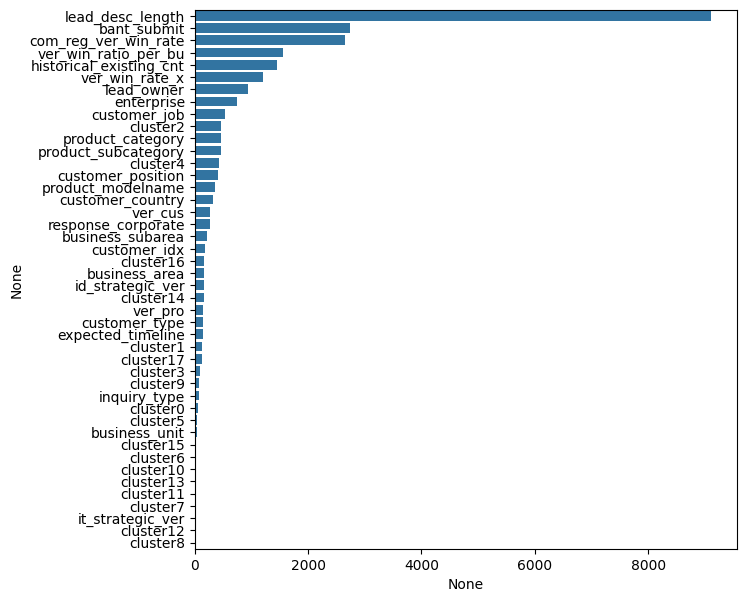

In [33]:
# LightGBM 모델 Feature Importance 시각화
lgb_feature_score = pd.Series(lgb_model.feature_importances_, index = x_train1.columns).sort_values(ascending=False)
plt.figure(figsize=(7,7))
sns.barplot(x = lgb_feature_score, y=lgb_feature_score.index)

# Catboost

In [34]:
# category type 컬럼 인덱스 저장
categorical_features = []
for i, col in enumerate(x_train2.columns):
    if x_train2[col].dtypes=='category':
        categorical_features.append(i)

pd.DataFrame.iteritems = pd.DataFrame.items

In [35]:
# bool > int 형변환
y_train2 = y_train2.astype(int)
y_val2 = y_val2.astype(int)

In [36]:
# 클래스 불균형 해결을 위한 class weight 부여
classes = np.unique(y_train2)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train2)
class_weights = dict(zip(classes, weights))

In [37]:
# Stratified K-Fold 교차 검증 수행
fold = 5
skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=SEED)
test_preds = np.zeros(x_test2.shape[0])
val_preds = np.zeros(x_val2.shape[0])
feature_importances = np.zeros(x_train2.shape[1])

for train_index, valid_index in skf.split(x_train2, y_train2):
    X_train, X_valid = x_train2.iloc[train_index], x_train2.iloc[valid_index]
    Y_train, Y_valid = y_train2.iloc[train_index], y_train2.iloc[valid_index]

    Y_train = Y_train.astype('int')
    Y_valid = Y_valid.astype('int')

    ctb_model = CatBoostClassifier(n_estimators = 10000, # 트리 개수
                            learning_rate =  0.07, # 학습률
                            eval_metric = 'F1', # 평가 지표 설정
                            loss_function = 'Logloss', # 손실 함수 설정
                            random_seed = SEED,
                            metric_period = 100,
                            class_weights = class_weights,
                            od_wait = 100, # early stopping round
                            depth =  6, # 트리 최고 깊이
                            rsm = 0.8, # 피처 샘플링 비율
                            cat_features=categorical_features)

    ctb_model.fit(X_train,Y_train, eval_set=[(X_valid,Y_valid)])

    # Feature Importance 평균
    feature_importances += (ctb_model.get_feature_importance()/fold)

    # stratifiedkfold val에 대한 예측
    y_pred = ctb_model.predict_proba(X_valid)[:,1] # skf val 예측
    y_pred = np.where(y_pred >= 0.5, True, False)
    # 성능 확인
    get_clf_eval(Y_valid, y_pred)

    val_preds += (ctb_model.predict_proba(x_val2)[:,1] / fold) # val 예측 확률 평균
    test_preds += (ctb_model.predict_proba(x_test2[ctb_model.feature_names_])[:,1] / fold) # test 예측 확률 평균

0:	learn: 0.8576566	test: 0.8777587	best: 0.8777587 (0)	total: 304ms	remaining: 50m 42s
100:	learn: 0.9435251	test: 0.9541552	best: 0.9551108 (90)	total: 11.6s	remaining: 19m
200:	learn: 0.9531822	test: 0.9576038	best: 0.9576038 (197)	total: 24.5s	remaining: 19m 52s
300:	learn: 0.9608089	test: 0.9594664	best: 0.9601342 (299)	total: 37s	remaining: 19m 51s
400:	learn: 0.9666146	test: 0.9572680	best: 0.9606914 (309)	total: 49.6s	remaining: 19m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9606913586
bestIteration = 309

Shrink model to first 310 iterations.
오차행렬:
 [[ 749   27]
 [ 385 8327]]

정확도: 0.9566
정밀도: 0.6605
재현율: 0.9652
F1: 0.7843


0:	learn: 0.8485801	test: 0.8688245	best: 0.8688245 (0)	total: 102ms	remaining: 16m 57s
100:	learn: 0.9464262	test: 0.9473125	best: 0.9487704 (92)	total: 14.2s	remaining: 23m 16s
200:	learn: 0.9565860	test: 0.9501371	best: 0.9502898 (160)	total: 26.8s	remaining: 21m 48s
300:	learn: 0.9624528	test: 0.9483291	best: 0.9516850 (231)	total: 39.5s	remaining: 21m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9516850183
bestIteration = 231

Shrink model to first 232 iterations.
오차행렬:
 [[ 739   37]
 [ 427 8285]]

정확도: 0.9511
정밀도: 0.6338
재현율: 0.9523
F1: 0.7611


0:	learn: 0.8482404	test: 0.8643950	best: 0.8643950 (0)	total: 109ms	remaining: 18m 6s
100:	learn: 0.9454958	test: 0.9506490	best: 0.9506490 (93)	total: 12.5s	remaining: 20m 25s
200:	learn: 0.9559842	test: 0.9536367	best: 0.9536367 (200)	total: 25.1s	remaining: 20m 21s
300:	learn: 0.9622053	test: 0.9534366	best: 0.9559211 (284)	total: 36.8s	remaining: 19m 46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9559210578
bestIteration = 284

Shrink model to first 285 iterations.
오차행렬:
 [[ 740   36]
 [ 362 8350]]

정확도: 0.9581
정밀도: 0.6715
재현율: 0.9536
F1: 0.7881


0:	learn: 0.8492125	test: 0.8427498	best: 0.8427498 (0)	total: 112ms	remaining: 18m 37s
100:	learn: 0.9464665	test: 0.9282712	best: 0.9289200 (96)	total: 12.6s	remaining: 20m 30s
200:	learn: 0.9565179	test: 0.9339651	best: 0.9372359 (177)	total: 25.1s	remaining: 20m 21s
300:	learn: 0.9634480	test: 0.9357169	best: 0.9378686 (289)	total: 37.8s	remaining: 20m 17s
400:	learn: 0.9684913	test: 0.9408561	best: 0.9409111 (396)	total: 50.8s	remaining: 20m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9409111339
bestIteration = 396

Shrink model to first 397 iterations.
오차행렬:
 [[ 716   60]
 [ 336 8376]]

정확도: 0.9583
정밀도: 0.6806
재현율: 0.9227
F1: 0.7834


0:	learn: 0.8390930	test: 0.8544797	best: 0.8544797 (0)	total: 109ms	remaining: 18m 12s
100:	learn: 0.9469637	test: 0.9453564	best: 0.9465023 (76)	total: 11.7s	remaining: 19m 7s
200:	learn: 0.9558326	test: 0.9519537	best: 0.9524855 (168)	total: 23.3s	remaining: 18m 57s
300:	learn: 0.9616484	test: 0.9519141	best: 0.9536192 (246)	total: 36.1s	remaining: 19m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9536191878
bestIteration = 246

Shrink model to first 247 iterations.
오차행렬:
 [[ 737   39]
 [ 367 8344]]

정확도: 0.9572
정밀도: 0.6676
재현율: 0.9497
F1: 0.7840


In [38]:
# Catboost 모델 오차 행렬
y_val_pred = np.where(val_preds>=0.5, 1, 0)
get_clf_eval(y_val2, y_val_pred)

오차행렬:
 [[  907    63]
 [  454 10436]]

정확도: 0.9564
정밀도: 0.6664
재현율: 0.9351
F1: 0.7782


In [39]:
# Catboost 모델 Test 데이터에 대해 True로 예측된 개수
test_pred = np.where(test_preds>=0.5, 1, 0).astype('bool')
sum(test_pred)

1829

<Axes: xlabel='None', ylabel='None'>

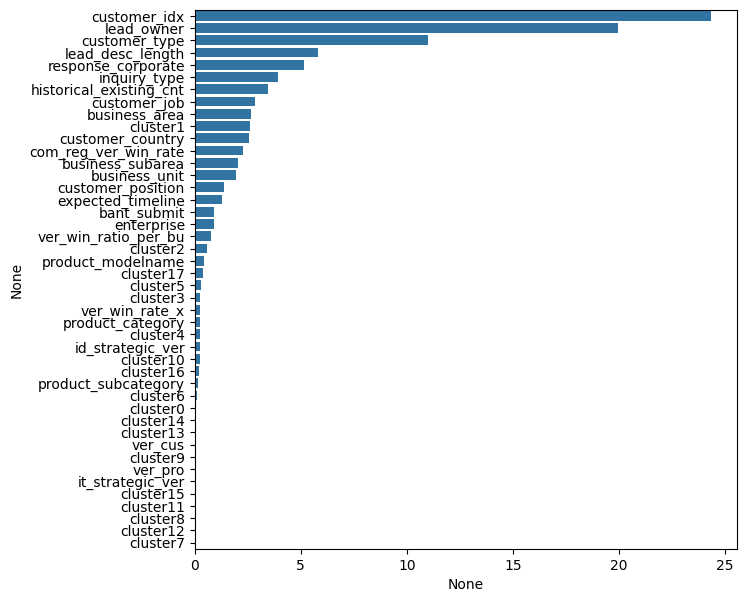

In [40]:
# Catboost 모델 Feature importance 시각화
ctb_feature_score = pd.Series(feature_importances, index = x_train2.columns).sort_values(ascending=False)
plt.figure(figsize=(7,7))
sns.barplot(x = ctb_feature_score, y=ctb_feature_score.index)

# lgbm+ctb 확률

In [41]:
lgb_val = lgb_model.predict_proba(x_val1)[:,1] # LightGBM의 validation에 대한 예측값
ctb_val = val_preds # Catboost의 validation에 대한 예측값

# recall이 높은 catboost에 더 가중치주어 새로운 확률 생성
# 비율 LightGBM : Catboost = 3 : 7
prob_val = (0.3 * lgb_val + 0.7 * ctb_val)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5183918408374883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5183918408374883
[LightGBM] [Warning] lambda_l2 is set=2.533704222692857e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.533704222692857e-07
[LightGBM] [Warning] lambda_l1 is set=0.013838831287919526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013838831287919526
[LightGBM] [Warning] bagging_fraction is set=0.8498576580360917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8498576580360917


In [42]:
# recall을 높이기 위해 임계치 0.4로 낮춤
val_pred40 = np.where(prob_val>=0.4, 1, 0)

# val 성능
get_clf_eval(y_val, val_pred40)

오차행렬:
 [[  910    60]
 [  446 10444]]

정확도: 0.9573
정밀도: 0.6711
재현율: 0.9381
F1: 0.7825


In [43]:
# test 예측
lgb_test = lgb_model.predict_proba(x_test1)[:,1]
ctb_test = test_preds

# test에 대한 확률값
prob_test = (0.3 * lgb_test + 0.7 * ctb_test)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5183918408374883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5183918408374883
[LightGBM] [Warning] lambda_l2 is set=2.533704222692857e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.533704222692857e-07
[LightGBM] [Warning] lambda_l1 is set=0.013838831287919526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013838831287919526
[LightGBM] [Warning] bagging_fraction is set=0.8498576580360917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8498576580360917


In [44]:
# 임계값 0.4로 낮춤
test_pred40 = np.where(prob_test>=0.4, 1, 0)

sum(test_pred40) # True로 예측된 개수

1769

In [45]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("/content/drive/MyDrive/LG Aimers/submission.csv")
df_sub["is_converted"] = test_pred40

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)